In [89]:
import tensorflow as tf
import numpy as np
import pandas as pd

In [90]:
train_data = tf.keras.utils.image_dataset_from_directory(
    'dataset/training',
    validation_split=0.1,  
    subset="training",     
    seed=42,               
    image_size=(128, 128), 
    batch_size=32          
)


Found 8005 files belonging to 2 classes.
Using 7205 files for training.


In [91]:
valid_data = tf.keras.utils.image_dataset_from_directory(
    'dataset/training',
    validation_split=0.1,  
    subset="validation",   
    seed=42,               
    image_size=(128, 128), 
    batch_size=32          
)


Found 8005 files belonging to 2 classes.
Using 800 files for validation.


In [92]:
data_iterator = train_data.as_numpy_iterator()
images, labels = data_iterator.next()


In [93]:
def normalizer(image, label):
    aux = tf.cast(image, dtype=tf.float32)
    image_norm = aux/255.0
    return image_norm, label

train = train_data.map(normalizer)
valid = valid_data.map(normalizer) 
    

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization, Dropout

model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(128,128,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(4, 4))
model.add(Dropout(0.2))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(4, 4))
model.add(Dropout(0.2))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(4, 4))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(units=1, activation='sigmoid'))


In [95]:
#model.compile(optimizer='adam', loss=tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'],
)

In [96]:
model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_42 (Conv2D)              │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_52          │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_49 (Dropout)            │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_53          │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_50 (Dropout)            │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_54          │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_51 (Dropout)            │ (None, 1, 1, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_14 (Flatten)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_55          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_52 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,449 (501.75 KB)

 Trainable params: 127,489 (498.00 KB)

 Non-trainable params: 960 (3.75 KB)

In [97]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [98]:
hist = model.fit(
    train,
    batch_size=32, 
    epochs=20, 
    validation_data=valid,
    callbacks=[early_stopping], 
    verbose=1
)

Epoch 1/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 30s 119ms/step - accuracy: 0.5563 - loss: 0.8830 - val_accuracy: 0.4950 - val_loss: 1.2943
Epoch 2/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 119ms/step - accuracy: 0.6088 - loss: 0.7227 - val_accuracy: 0.5038 - val_loss: 0.8825
Epoch 3/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 118ms/step - accuracy: 0.6370 - loss: 0.6520 - val_accuracy: 0.6212 - val_loss: 0.6658
Epoch 4/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 28s 122ms/step - accuracy: 0.6794 - loss: 0.6096 - val_accuracy: 0.6125 - val_loss: 0.6554
Epoch 5/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7072 - loss: 0.5629 - val_accuracy: 0.5400 - val_loss: 0.7710
Epoch 6/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7422 - loss: 0.5358 - val_accuracy: 0.7100 - val_loss: 0.5730
Epoch 7/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 26s 117ms/step - accuracy: 0.7409 - loss: 0.5198 - val_accuracy: 0.7138 - val_loss: 0.5604
Epoch 8/20
226/226 ━━━━━━━━━━━━━━━━━━━━ 27s 120ms/step - accuracy: 0.7699 - loss: 0

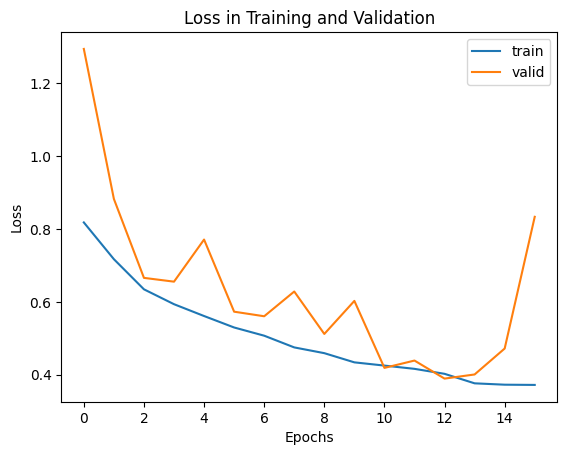

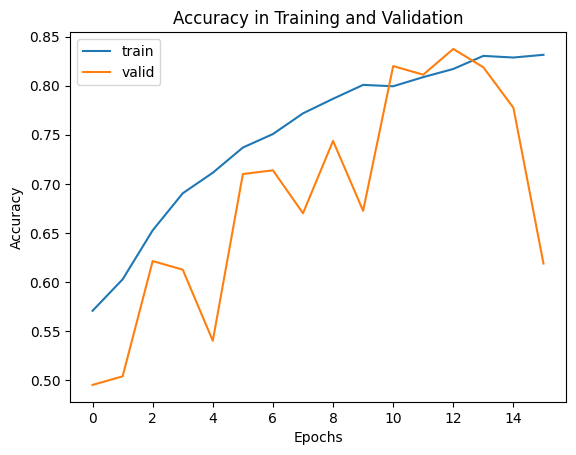

In [99]:
import matplotlib.pyplot as plt


plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss in Training and Validation')
plt.show()


if 'accuracy' in hist.history: 
    plt.plot(hist.history['accuracy'], label='train')
    plt.plot(hist.history['val_accuracy'], label='valid')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy in Training and Validation')
    plt.show()